<h1>Capstone Project - Proposing Locations for a Bubble Tea Store in Vancouver (Week 2)</h1>
<h2> Applied Data Science Capstone by IBM/Coursera <h2>

<h3> Table of Contents </h3>
<ol> 
    <li> <a href="#Intro"> Introduction/Business Problem </a></li>
    <li>  <a href="#Data"> Data </a> </li>
    <li> <a href="#Methodology"> Methodology </a> </li>
    <li> <a href="#Results"> Results </a> </li>
    <li> <a href="#Discussion"> Discussion</a> </li>
    <li> <a href="#Conclusion"> Conclusion</a> </li>

</ol>

### <div id="Intro">Introduction/Business Problem </div>

This project proposes good locations in Vancouver for opening a bubble tea store. It is aimed to provide help to any person wanting to start a business in Vancouver with relatively small initial capital or a chain that wants to open a location in Vancouver.

Bubble tea is a drink that can be made using a variety of ingredients such as tea, juice or sweetened flavoured milk usually with sweet black tapioca pearls.

<div style=" font-size:80%; text-align:center;padding-top:1em"><img src="bubble_tea.jpeg" alt="Bubble tea image"  style="padding-bottom:0.5em;" />Bubble tea (image from https://www.thecoast.ca)</div>

Starting a bubble tea store is relatively inexpensive, since it requires less equipment than a traditional coffee shop or restaurant and the profit margins are high because the ingredients, such as tea, are inexpensive. Also, preparing bubble tea is easy, so not much staff training is required.

Bubble tea originated in Taiwan in the early 1980s and is gaining popularity around the world. For example, the Taiwnese chain Chatime currently has 2500+ locations around the world (https://en.wikipedia.org/wiki/Chatime) but only 3 in Vancouver.

The number of all bubble tea stores in Vancouver is around 60 (results from https://foursquare.com), whereas there are 108 Starbucks in Vancouver as of February 2019 (https://www.statista.com/statistics/306896/cities-with-the-largest-number-of-starbucks-stores-worldwide/) and there are also numerous other coffee shops.

Bubble tea is especially popular with tweens and going for bubble tea after school is loved by Vancouver school children.

Because of this, to propose a good location for a bubble tea store we look for locations in Vancouver that are close to schools. In particular, we look at schools that have no bubble tea stores within 800m, determine if a school is "walkable" and highlight the commercial zones that allow for opening of a bubble tea store near the school. 

We say that a school is "walkable" using a definition of a walk score (a number between 0 and 100) on https://www.walkscore.com/methodology.shtml:

_Walk Score measures the walkability of any address using a patented system. For each address, Walk Score analyzes hundreds of walking routes to nearby amenities. Points are awarded based on the distance to amenities in each category. Amenities within a 5 minute walk (.25 miles) are given maximum points. A decay function is used to give points to more distant amenities, with no points given after a 30 minute walk._

_Walk Score also measures pedestrian friendliness by analyzing population density and road metrics such as block length and intersection density. Data sources include Google, Education.com, Open Street Map, the U.S. Census, Localeze, and places added by the Walk Score user community._

The commercial zones we focus on have high pedestrian traffic, which is also very good for a bubble tea store.


### <div id="Data"> Data </div>

To recommend good locations for a bubble tea stores as outlined in the introduction we need the following data:

* __The number and locations of all bubble tea stores in Vancouver,__<br>
These are obtained from https://foursquare.com/  The names and the latitude and longitude of all bubble tea stores can be obtained from here.
    
    
* __The locations of all elementary and high schools in Vancouver,__<br>
These are obtained from https://data.vancouver.ca/datacatalogue/schools.htm which has a more comprehensive list than https://foursquare.com/ The file includes the names, addresses and longitude and latitude of the schools. This is important for both data processing and visualization.
    
    
* __The locations of all commercial zones,__<br>
These are obtained from https://data.vancouver.ca/datacatalogue/zoning.htm. I will use the .kml file to extract the polygons that choropleth maps need, so I can then visualize the zones on a map.


* __The walkability of school locations,__<br>
These are obtained from https://www.walkscore.com using their API. 

<h4> Data Collection </h4>

In order to start the data collection, first we need to import required packages.

In [9]:
import json
import requests
import pandas as pd
import folium
import urllib

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy import distance # for calculating the distance between two points
from geopy import Point

We will define constants so we can easily experiment with different values.

We will be looking for the bubble tea stores within <b> RADIUS </b> meters from a school. The value of 800m was chosen, because it can be walked in about 10 minutes, which seems like a reasonable distance to walk for children.

We will only look at schools that are at most <b> LIMIT_1 </b> kilometres away from a commercial district that allows for opening of a bubble tea store. The commercial zones are specified by the polygon of longitudes and latitudes, and the distance between a school and a commercial zone will be the minimum distance between the school and a point in the polygon. <b> LIMIT_1 </b>is set to be equal to <b> RADIUS </b>, but potentially we could make it a bit larger to aim for the centre of a commercial zone.




In [2]:
RADIUS = 800 #look to see if there are bubble tea stores within this radius
LIMIT_1 = 0.8 #distance to the commercial district

Put all credentials here, so I don't forget earsing them before posting on github.

In [3]:
CLIENT_ID = '' #Foursquare ID
CLIENT_SECRET = '' #Foursquare Secret
VERSION = '20180605' #API version

WSAPIKEY_WS = '' #for Walkscore


<b> Get a list of all bubble tea stores in Vancouver, BC </b>and print its length (number of stores).

In [4]:
CATEGORY = '52e81612bcbc57f1066b7a0c' #Foursquare category for bubble tea store
NEAR = 'VANCOUVER, BC'

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&categoryId={}&limit=200'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            NEAR, 
            CATEGORY)
            
# make the GET request
bubble_tea_shops = requests.get(url).json()["response"]['groups'][0]['items']

print("Number of bubble tea stores in Vancouver is", len(bubble_tea_shops))

Number of bubble tea stores in Vancouver is 60


Now that we know the number of bubble tea stores in Vancouver, let's look of what the data looks like.

In [5]:
print(bubble_tea_shops[0:5])

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4aa846f9f964a520945020e3', 'name': 'Dragon Ball Tea House', 'location': {'address': '1007 West King Edward Ave.', 'crossStreet': 'btwn Oak & Osler St', 'lat': 49.24912633116664, 'lng': -123.12771828289415, 'labeledLatLngs': [{'label': 'display', 'lat': 49.24912633116664, 'lng': -123.12771828289415}], 'postalCode': 'V6H 2W9', 'cc': 'CA', 'city': 'Vancouver', 'state': 'BC', 'country': 'Canada', 'formattedAddress': ['1007 West King Edward Ave. (btwn Oak & Osler St)', 'Vancouver BC V6H 2W9', 'Canada']}, 'categories': [{'id': '52e81612bcbc57f1066b7a0c', 'name': 'Bubble Tea Shop', 'pluralName': 'Bubble Tea Shops', 'shortName': 'Bubble Tea', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bubble_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4aa846f9f964a520945020e3-0'}, {'rea

Note that some stores don't have an address, so use 'Not provided' instead when extract the information we need from the list into a pandas dataframe bubble_tea_df.

In [6]:
venues_list = []  

venues_list.append([(
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['location'].get('address', 'Not provided')
            ) for v in bubble_tea_shops])


bubble_tea_df = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
bubble_tea_df.columns = ['Name', 
                  'Latitude', 
                  'Longitude', 
                  'Address']
bubble_tea_df

,Name,Latitude,Longitude,Address
0,Dragon Ball Tea House,49.249126,-123.127718,1007 West King Edward Ave.
1,Milk & Sugar Café,49.233249,-123.034086,3365 Kingsway
2,Mr. Mustache Bubble Tea,49.212458,-123.140451,8079 Granville Street
3,Moii Cafe,49.262679,-123.114812,2559 Cambie St
4,Green Leaf Bubble Tea,49.232289,-123.090457,5756 Fraser St
5,Chatime,49.286793,-123.128012,1274 Robson Street
6,Xing Fu Tang,49.254506,-123.114986,3432 Cambie St
7,Bubble World,49.287322,-123.128919,1325 Robson St
8,DAVIDsTEA,49.283674,-123.123392,1024 Robson St. Unit 0700
9,Share Tea,49.260030,-123.114870,2828 Cambie St


The dataframe looks good. No other cleaning is required.

I tried getting the list of schools in Vancouver from Foursquare, but it turns out that there is a more comprehensive list on the city website ftp://webftp.vancouver.ca/OpenData/csv/schools.csv so I decided to use that data.

<b> Get a list of schools in Vancouver </b>

In [7]:
#the city has a more comprehensive list of schools
schools1 = pd.read_csv('ftp://webftp.vancouver.ca/OpenData/csv/schools.csv')
schools1.head()

,SCHOOL_NAME,LATITUDE,LONGITUDE,ADDRESS,SCHOOL_CATEGORY
0,Admiral Seymour Elementary,49.278594,-123.080314,1130 Keefer St,Public School
1,Admiral Seymour StrongStart Centre,49.278594,-123.080314,1130 Keefer St,StrongStart BC
2,Alexander Academy,49.285001,-123.114010,688 W Hastings St,Independent School
3,Anchor Point Montessori,49.277062,-123.130919,1351 Hornby St,Independent School
4,BC Children's Adol. Psych. Unit,49.239631,-123.125791,5025 Willow St,Public School


The csv file provided by the city contains exactly the information we need. No cleaning necessary.

Now, we get a <b>Walk score</b> for each school. This can take a while, so we print the names of processed schools. We also include the bike score, but do not use it in this project. This number is interesting and could be used for further analysis later.

In [10]:
for index, row in schools1.iterrows():
    
    print(row['SCHOOL_NAME'])
    address = urllib.parse.quote(row['ADDRESS'])

    parameters = {'address':urllib.parse.quote(row['ADDRESS']),'lat':row['LATITUDE'], 'lon':row['LONGITUDE']}
    encoded = 'http://api.walkscore.com/score?format=json&'+ urllib.parse.urlencode(parameters,quote_via=urllib.parse.quote_plus,doseq=False, safe='', encoding=None, errors=None, )+'&transit=1&bike=1&wsapikey='+WSAPIKEY_WS
    

    results = requests.get(encoded).json()

    schools1.at[index,'WALK_SCORE'] =results['walkscore']
    schools1.at[index,'BIKE_SCORE'] =results['bike']['score']

schools1

Admiral Seymour Elementary
Admiral Seymour StrongStart Centre
Alexander Academy
Anchor Point Montessori
BC Children's Adol. Psych. Unit
BC Childrens Hosp School Program
BCCH Eating Disorders School Program
Bayview Community Elementary
Blessed Sacrament School
Britannia Community Elementary
Britannia Community Secondary
Canuck Place School Program
Captain James Cook Elementary
Captain James Cook StrongStart Centre
Carnarvon Community Elementary
Century High School
Champlain Heights Annex
Champlain Heights Annex StrongStart Cntr
Champlain Heights Community Elementary
Charles Dickens Annex
Charles Dickens Elementary
Chief Maquinna Annex
Chief Maquinna Elementary
Chief Maquinna StrongStart Centre
Children's Hearing and Speech Centre BC
Collingwood Neighbourhood School
Collingwood StrongStart Centre
Columbia College
Continuing Ed SD 39
Corpus Christi School
Crofton House
Crosstown Elementary
David Livingstone Elementary
David Lloyd George Elementary
David Lloyd George StrongStart Centre
Dav

,SCHOOL_NAME,LATITUDE,LONGITUDE,ADDRESS,SCHOOL_CATEGORY,WALK_SCORE,BIKE_SCORE
0,Admiral Seymour Elementary,49.278594,-123.080314,1130 Keefer St,Public School,90.0,73.0
1,Admiral Seymour StrongStart Centre,49.278594,-123.080314,1130 Keefer St,StrongStart BC,90.0,73.0
2,Alexander Academy,49.285001,-123.114010,688 W Hastings St,Independent School,98.0,61.0
3,Anchor Point Montessori,49.277062,-123.130919,1351 Hornby St,Independent School,98.0,67.0
4,BC Children's Adol. Psych. Unit,49.239631,-123.125791,5025 Willow St,Public School,59.0,54.0
5,BC Childrens Hosp School Program,49.239631,-123.125791,5025 Willow St,Public School,59.0,54.0
6,BCCH Eating Disorders School Program,49.239631,-123.125791,5025 Willow St,Public School,59.0,54.0
7,Bayview Community Elementary,49.266487,-123.182334,2251 Collingwood St,Public School,94.0,63.0
8,Blessed Sacrament School,49.258338,-123.119391,3020 Heather St,Independent School,93.0,68.0
9,Britannia Community Elementary,49.274512,-123.071379,1110 Cotton Drive,Public School,97.0,64.0


In [11]:
schools1


,SCHOOL_NAME,LATITUDE,LONGITUDE,ADDRESS,SCHOOL_CATEGORY,WALK_SCORE,BIKE_SCORE
0,Admiral Seymour Elementary,49.278594,-123.080314,1130 Keefer St,Public School,90.0,73.0
1,Admiral Seymour StrongStart Centre,49.278594,-123.080314,1130 Keefer St,StrongStart BC,90.0,73.0
2,Alexander Academy,49.285001,-123.114010,688 W Hastings St,Independent School,98.0,61.0
3,Anchor Point Montessori,49.277062,-123.130919,1351 Hornby St,Independent School,98.0,67.0
4,BC Children's Adol. Psych. Unit,49.239631,-123.125791,5025 Willow St,Public School,59.0,54.0
5,BC Childrens Hosp School Program,49.239631,-123.125791,5025 Willow St,Public School,59.0,54.0
6,BCCH Eating Disorders School Program,49.239631,-123.125791,5025 Willow St,Public School,59.0,54.0
7,Bayview Community Elementary,49.266487,-123.182334,2251 Collingwood St,Public School,94.0,63.0
8,Blessed Sacrament School,49.258338,-123.119391,3020 Heather St,Independent School,93.0,68.0
9,Britannia Community Elementary,49.274512,-123.071379,1110 Cotton Drive,Public School,97.0,64.0


Now, we load the <b> commercial zones information</b>. The zoning information for Vancouver can be found at https://data.vancouver.ca/datacatalogue/zoning.htm and the description of each zone at https://vancouver.ca/home-property-development/zoning-map-districts-and-regulations.aspx.

I used the kmz file that I unzipped to my local computer and then used https://mygeodata.cloud/converter/kml-to-json converter to convert from .kml to .json format. The created file is zoning_districts.geojson. All these files are included on github.

It is possible to write a converter code here, but I am running out of time.

It seems that the zones that one could surely open a bubble tea shop are zones C and zones that start with FC. The code below finds these zones and stores them in the file 'created_data.geojson'.

I have decided not to include the Comprehensive Development District (CD) zones listed at https://vancouver.ca/home-property-development/cd-1-comprehensive-development-district.aspx as these zones are either very residential (no possibility for opening a bubble tea store) or very commercial (likely already contain a bubble tea store). 

A description that is just the index number of the feature is added to each feature.


In [12]:
file = open("zoning_districts.geojson", "r")
data=file.read()
json_data = json.loads(data)

geo_json_list = []

feature_description = 0 

for i in range(len(json_data['features'])):
    if json_data['features'][i]['properties']['ZONE_CATEGORY'] == 'C' or "FC" in json_data['features'][i]['properties']['ZONE_CATEGORY']:
        json_data['features'][i]['properties']['description'] = str(feature_description)
        feature_description = feature_description + 1
        geo_json_list.append(json_data['features'][i])

f = open('created_data.geojson','w')
f.write('{\n')
f.write('"type": "FeatureCollection",\n"name": "Zoning_Districts",\n"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },')
f.write('\n"features":\n')

json.dump(geo_json_list, f)

f.write('\n}')

f.close()


Load the commercial zone json data in a dataframe and inspect the data.

In [16]:

data = json.load(open('created_data.geojson'))

zoning = pd.DataFrame(columns=['Type', 'Geometry'])

for i in range(len(data['features'])):
    geom = data['features'][i]['geometry']['coordinates']
 
    zoning.loc[i]=[data['features'][i]['properties']['Name'],data['features'][i]['geometry']['coordinates'][0]]

zoning.head()

,Type,Geometry
0,C-1,"[[-123.023715460293, 49.2570550023475], [-123...."
1,C-1,"[[-123.056588598485, 49.2704335406909], [-123...."
2,C-1,"[[-123.117133052336, 49.2335758214673], [-123...."
3,C-1,"[[-123.06511078278, 49.2222279200206], [-123.0..."
4,C-1,"[[-123.032995714877, 49.2618915896521], [-123...."


Visualize the data

In [17]:
address = 'Vancouver, BC'

geolocator = Nominatim(user_agent="Vancouver_bubble_tea")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


#This function is used in labelling the graph
def my_description_function(feature):
    
    return str(feature['properties']['description']) 


map_vis = folium.Map(location=[latitude, longitude], zoom_start=12)

geo_json_data = json.load(open('created_data.geojson'))

#add the zones to the map
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': '#721472',
        'color' : '#721472',
        'fill_opacity': 0.7,
        'weight' : 1,
        'line_opacity':0.6,
        'label':my_description_function(feature)
        }
        
    ).add_to(map_vis)


folium.LayerControl().add_to(map_vis)


# add bubble tea markers to map
for lat, lng, name, address in zip(bubble_tea_df['Latitude'], bubble_tea_df['Longitude'], bubble_tea_df['Name'], bubble_tea_df['Address']):
    label = '{} Address: {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_vis)  
    

#add schools to map
for lat, lng, name, kind in zip(schools1['LATITUDE'], schools1['LONGITUDE'], schools1['SCHOOL_NAME'], schools1['SCHOOL_CATEGORY']):
    label = '{} Kind: {}'.format(name, kind)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#00aa00',
        fill=True,
        fill_color='#00aa00',
        fill_opacity=0.6).add_to(map_vis)

#this legend was the biggest pain in a long time. Please let me know if you can make it easier.
legend_html = '''  
     <div style="position: fixed;top: 50px; left: 50px; width: 200px; height: 60px; 
     border:2px solid grey; z-index:9999; font-size:12px;">
     
     &nbsp; School locations &nbsp; <i style="height:10px; width:10px; background-color: #00aa00; border-radius: 50%;
  display: inline-block;"></i><br>
  
       &nbsp; Bubble tea stores &nbsp; <i style="height:10px; width:10px; background-color: #0000ff; border-radius: 50%;
  display: inline-block;"></i><br>
  
    &nbsp; Commercial districts &nbsp; <i style="height: 2px;width: 25px;border-bottom: 2px solid #721472;
  display: inline-block;""></i>
  
      </div>
     '''

map_vis.get_root().html.add_child(folium.Element(legend_html))

map_vis.save('map_vis.html')

print("Schools, bubble tea locations and commercial zones in Vancouver")   
map_vis

Schools, bubble tea locations and commercial zones in Vancouver


Get the number of bubble tea stores in the radius RADIUS (defined on top) from each school. I decided to rely on Foursquare instead of calculating distances.

In [15]:
CATEGORY = '52e81612bcbc57f1066b7a0c' #bubble tea

for index, row in schools1.iterrows():
    
    LL = str(row['LATITUDE'])+ "," + str(row['LONGITUDE'])
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={}&limit=200'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            LL,
            str(RADIUS),
            CATEGORY)
    
    
    close_stores = requests.get(url).json()["response"]['groups'][0]['items']
    
    print("ind =", index)
                            
    schools1.at[index,'NUM_CLOSE_STORES'] = len(close_stores)


schools1




ind = 0
ind = 1
ind = 2
ind = 3
ind = 4
ind = 5
ind = 6
ind = 7
ind = 8
ind = 9
ind = 10
ind = 11
ind = 12
ind = 13
ind = 14
ind = 15
ind = 16
ind = 17
ind = 18
ind = 19
ind = 20
ind = 21
ind = 22
ind = 23
ind = 24
ind = 25
ind = 26
ind = 27
ind = 28
ind = 29
ind = 30
ind = 31
ind = 32
ind = 33
ind = 34
ind = 35
ind = 36
ind = 37
ind = 38
ind = 39
ind = 40
ind = 41
ind = 42
ind = 43
ind = 44
ind = 45
ind = 46
ind = 47
ind = 48
ind = 49
ind = 50
ind = 51
ind = 52
ind = 53
ind = 54
ind = 55
ind = 56
ind = 57
ind = 58
ind = 59
ind = 60
ind = 61
ind = 62
ind = 63
ind = 64
ind = 65
ind = 66
ind = 67
ind = 68
ind = 69
ind = 70
ind = 71
ind = 72
ind = 73
ind = 74
ind = 75
ind = 76
ind = 77
ind = 78
ind = 79
ind = 80
ind = 81
ind = 82
ind = 83
ind = 84
ind = 85
ind = 86
ind = 87
ind = 88
ind = 89
ind = 90
ind = 91
ind = 92
ind = 93
ind = 94
ind = 95
ind = 96
ind = 97
ind = 98
ind = 99
ind = 100
ind = 101
ind = 102
ind = 103
ind = 104
ind = 105
ind = 106
ind = 107
ind = 108
ind = 109
ind = 110


KeyboardInterrupt: 

In [18]:
schools1.tail(100)


,SCHOOL_NAME,LATITUDE,LONGITUDE,ADDRESS,SCHOOL_CATEGORY,WALK_SCORE,BIKE_SCORE,NUM_CLOSE_STORES
94,Magee Secondary,49.228554,-123.151538,6360 Maple St,Public School,70.0,74.0,2.0
95,Maple Grove Elementary,49.229409,-123.151515,6199 Cypress St,Public School,78.0,74.0,4.0
96,Mount Pleasant Elementary,49.263966,-123.094000,2300 Guelph St,Public School,97.0,60.0,3.0
97,Mount Pleasant StrongStart Centre,49.263966,-123.094000,2300 Guelph St,StrongStart BC,97.0,60.0,3.0
98,Nootka Community Elementary,49.253593,-123.042949,3375 Nootka St,Public School,76.0,56.0,1.0
99,Norma Rose Point School,49.257792,-123.201128,4102 W 16th Av,Public School,57.0,65.0,0.0
100,Notre Dame Regional Secondary,49.275803,-123.045567,2880 Venables St,Independent School,78.0,60.0,2.0
101,Our Lady of Perpetual Help,49.264135,-123.196179,2550 Camosun St,Independent School,67.0,51.0,0.0
102,Our Lady of Sorrows,49.279571,-123.050154,575 Slocan St,Independent School,91.0,66.0,2.0
103,PALS Autism School,49.280515,-123.055954,2409 E Pender St,Independent School,93.0,72.0,2.0


In [19]:
zoning.tail()

,Type,Geometry
175,C-2C1,"[[-123.068913575373, 49.2730301458534], [-123...."
176,C-2C1,"[[-123.031572123498, 49.2806988007888], [-123...."
177,C-3A,"[[-123.157685852969, 49.2633993886024], [-123...."
178,C-3A,"[[-123.095643377488, 49.2597666192989], [-123...."
179,FCCDD,"[[-123.140791662709, 49.2697037024639], [-123...."


For each school create a list of commercial districts that are within LIMIT_1 km of a point from a ploygon in json file. Add the lists to the schools1 dataframe.

In [20]:
#return True if a school is withing LIMIT_1 km of any commercial zone in district_geo_list
def is_school_close_to_district(school_lat, school_lng, district_geo_list):
    
    school_pt = Point(str(school_lat)+" "+ str( school_lng))
    
    for loc in district_geo_list:
        p2 = Point(str(loc[1])+" "+ str(loc[0]))
        if distance.distance(school_pt,p2).kilometers < LIMIT_1:
            return True
    return False

#get a list of districts that are close to the school
def get_list_of_close_districts(school_lat, school_lng, zoning):
    
    close_districts=[]
    for index, row in zoning.iterrows():
        if is_school_close_to_district(school_lat, school_lng, zoning.iloc[index]['Geometry']):
            close_districts.append(index)
    return close_districts

schools1["CLOSE_DISTRICTS"] = ""
schools1.CLOSE_DISTRICTS = schools1.CLOSE_DISTRICTS.astype(object)



#use the above function for every school
for index, row in schools1.iterrows():
    l = get_list_of_close_districts(row['LATITUDE'],row['LONGITUDE'], zoning)
    
    print(row['SCHOOL_NAME'],l)
    schools1.at[index,'CLOSE_DISTRICTS'] = l
    
    schools1.at[index,'NUM_DISTRICTS'] = len(l)
    

        

Admiral Seymour Elementary [175]
Admiral Seymour StrongStart Centre [175]
Alexander Academy []
Anchor Point Montessori [141, 154, 155, 179]
BC Children's Adol. Psych. Unit [2, 58, 59]
BC Childrens Hosp School Program [2, 58, 59]
BCCH Eating Disorders School Program [2, 58, 59]
Bayview Community Elementary [64, 85, 86, 87, 104, 119, 127, 128, 139]
Blessed Sacrament School [25, 82, 93, 95, 174, 177]
Britannia Community Elementary [94, 110, 129, 136, 175]
Britannia Community Secondary [94, 110, 129, 137, 175]
Canuck Place School Program [177]
Captain James Cook Elementary [36]
Captain James Cook StrongStart Centre [36]
Carnarvon Community Elementary [10, 13, 14, 62, 66, 127, 128]
Century High School [65, 115, 116, 120, 122, 135, 147, 148, 149, 150, 168, 170, 173, 177, 179]
Champlain Heights Annex []
Champlain Heights Annex StrongStart Cntr []
Champlain Heights Community Elementary []
Charles Dickens Annex [100, 101, 171]
Charles Dickens Elementary [38, 75, 101, 123, 171]
Chief Maquinna An

Tecumseh Elementary [5, 11, 74, 77, 160]
Templeton Secondary [23, 71, 76, 94, 107, 110, 126, 137, 175]
The Westside School [179]
Thunderbird Elementary [0, 4, 33, 49, 51]
Thunderbird StrongStart Centre [0, 4, 33, 49, 51]
Tillicum Annex StrongStart Centre [45, 57, 76, 111, 126, 137]
Tillicum Community Annex [45, 57, 76, 111, 126, 137]
Trafalgar Elementary [14, 62]
Tyee Elementary [38, 79, 130, 140, 167, 171]
Vancouver Alternate [115, 122, 148, 168, 173, 177, 179]
Vancouver Christian [0, 22, 33, 44]
Vancouver College [58, 59, 156]
Vancouver College DL [58, 59, 156]
Vancouver Formosa Academy [9, 30, 35, 96, 163, 164]
Vancouver Hebrew Academy [6, 42, 69, 88, 89, 133, 158]
Vancouver Learning Network [103, 161]
Vancouver Montessori School [6, 69, 70, 88, 89, 133, 158, 166]
Vancouver Talmud Torah Elementary [113]
Vancouver Technical Secondary [24, 50, 61, 63, 106, 108, 157, 159]
Walter Moberly Elementary [17, 20, 26, 28]
Walter Moberly StrongStart Centre [17, 20, 26, 28]
Waverley Elementary [

In [21]:
schools1.head()

,SCHOOL_NAME,LATITUDE,LONGITUDE,ADDRESS,SCHOOL_CATEGORY,WALK_SCORE,BIKE_SCORE,NUM_CLOSE_STORES,CLOSE_DISTRICTS,NUM_DISTRICTS
0,Admiral Seymour Elementary,49.278594,-123.080314,1130 Keefer St,Public School,90.0,73.0,0.0,[175],1.0
1,Admiral Seymour StrongStart Centre,49.278594,-123.080314,1130 Keefer St,StrongStart BC,90.0,73.0,0.0,[175],1.0
2,Alexander Academy,49.285001,-123.114010,688 W Hastings St,Independent School,98.0,61.0,10.0,[],0.0
3,Anchor Point Montessori,49.277062,-123.130919,1351 Hornby St,Independent School,98.0,67.0,2.0,"[141, 154, 155, 179]",4.0
4,BC Children's Adol. Psych. Unit,49.239631,-123.125791,5025 Willow St,Public School,59.0,54.0,0.0,"[2, 58, 59]",3.0


Now we have the all the needed dataframes for the analysis.

<div id = "Methodology"><h3>Methodology</h3> </div>

In our analysis we will use the walk score of a school, rather than the number of close commercial districts we extracted from the city of Vancouver site. On https://www.walkscore.com/methodology.shtmlWalk it is stated: 

<i> Walk Score measures the walkability of any address using a patented system. For each address, Walk Score analyzes hundreds of walking routes to nearby amenities. Points are awarded based on the distance to amenities in each category. Amenities within a 5 minute walk (.25 miles) are given maximum points. A decay function is used to give points to more distant amenities, with no points given after a 30 minute walk.

Walk Score also measures pedestrian friendliness by analyzing population density and road metrics such as block length and intersection density. Data sources include Google, Education.com, Open Street Map, the U.S. Census, Localeze, and places added by the Walk Score user community. </i>

The walk score measure seems to be a much more sophisticated measure of pedestrian friendliness then the number of near by commercial districts. In fact, the map at http://vanmapp.vancouver.ca/pubvanmap_net/default.aspx?&showLayers=zoning_district_labels,zoning_districts shows that in some areas there are quite a few small commercial districts, i.e. that commercial districts in Vancouver can be quite fragmented. The area of the nearby commercial districts could be a better measure than the number of the districts, but the walk score still seems like a superior measure.

The Pearson correlation coefficient calculated below shows that 25% of the walk score variations can be explained by the number of nearby commercial zones we calculated. 

The scatterplot of the number of districts and walk score shows that are no schools with many commercial districts nearby that have a low walk score.

In [22]:
from scipy import stats
stats.pearsonr(schools1['NUM_DISTRICTS'], schools1['WALK_SCORE'])

(0.5033691662234406, 7.396162768893945e-14)

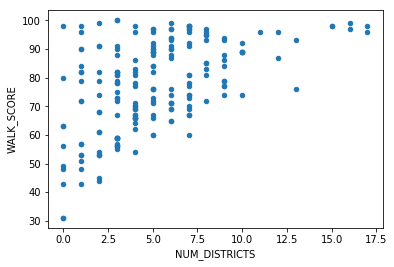

In [31]:
 ax1 = schools1.plot.scatter(x='NUM_DISTRICTS',y='WALK_SCORE')

Even if we take into account that the commercial districts can be fragmented and use a binary variable for each school that denotes if a school is close to a commercial distric or not, and then use Point-Biserial Correlation Coefficient that measures the strength of association between a continuous-level variable and a binary variable, we don't get a much better explanation of the variation.

In [24]:
x = schools1['WALK_SCORE'].values

y =[]

for i in schools1['NUM_DISTRICTS'].values:
    if i > 0:
        y.append(1)
    else:
        y.append(0)
        

print(stats.pointbiserialr(x,y))

PointbiserialrResult(correlation=0.32414839009232294, pvalue=4.011332830330197e-06)


Let's look at the schools that have no commercial districts nearby.

In [25]:
num_d = schools1['NUM_DISTRICTS'] == 0.0

schools1[num_d]

,SCHOOL_NAME,LATITUDE,LONGITUDE,ADDRESS,SCHOOL_CATEGORY,WALK_SCORE,BIKE_SCORE,NUM_CLOSE_STORES,CLOSE_DISTRICTS,NUM_DISTRICTS
2,Alexander Academy,49.285001,-123.114010,688 W Hastings St,Independent School,98.0,61.0,10.0,[],0.0
16,Champlain Heights Annex,49.214078,-123.030550,7835 Champlain Crescent,Public School,63.0,35.0,0.0,[],0.0
17,Champlain Heights Annex StrongStart Cntr,49.214078,-123.030550,7835 Champlain Crescent,StrongStart BC,63.0,35.0,0.0,[],0.0
18,Champlain Heights Community Elementary,49.220640,-123.027748,6955 Frontenac St,Public School,56.0,46.0,0.0,[],0.0
79,Little Flower Academy,49.248431,-123.142261,4195 Alexandra St,Independent School,43.0,56.0,0.0,[],0.0
123,Royal Canadian College,49.207242,-123.118608,8610 Ash St,Independent School,80.0,68.0,2.0,[],0.0
125,Shaughnessy Elementary,49.248676,-123.143810,4250 Marguerite St,Public School,48.0,65.0,0.0,[],0.0
147,Southlands Elementary,49.238138,-123.197815,5351 Camosun St,Public School,31.0,44.0,0.0,[],0.0
153,St George's School,49.247582,-123.198465,4175 W 29th Av,Independent School,31.0,49.0,NaN,[],0.0
193,York House School,49.248848,-123.140340,4176 Alexandra St,Independent School,49.0,60.0,NaN,[],0.0


All but two of these stores are in very residential neighbourhoods. Alexander Academy is in CD zone and Royal Canadian College has a walk score of only 80, which is, for Vancouver, relatively low.

Therefore we focus on schools that have no nearby bubble tea stores, but do have a near by commercial zone and we will sort these schools by their walk scores in descending order.

In [26]:
no_stores = schools1['NUM_CLOSE_STORES'] == 0.0
close_distr = schools1['NUM_DISTRICTS'] > 0.0

possible_schools = schools1[no_stores & close_distr]

possible_schools.sort_values(by='WALK_SCORE', ascending=False)

,SCHOOL_NAME,LATITUDE,LONGITUDE,ADDRESS,SCHOOL_CATEGORY,WALK_SCORE,BIKE_SCORE,NUM_CLOSE_STORES,CLOSE_DISTRICTS,NUM_DISTRICTS
44,Elsie Roy Elementary,49.272238,-123.122482,150 Drake St,Public School,96.0,70.0,0.0,"[154, 155, 177, 179]",4.0
90,Lord Strathcona Community Elementary,49.279812,-123.091477,592 E Pender St,Public School,96.0,72.0,0.0,[151],1.0
7,Bayview Community Elementary,49.266487,-123.182334,2251 Collingwood St,Public School,94.0,63.0,0.0,"[64, 85, 86, 87, 104, 119, 127, 128, 139]",9.0
19,Charles Dickens Annex,49.250213,-123.082710,3877 Glen Drive,Public School,91.0,60.0,0.0,"[100, 101, 171]",3.0
0,Admiral Seymour Elementary,49.278594,-123.080314,1130 Keefer St,Public School,90.0,73.0,0.0,[175],1.0
1,Admiral Seymour StrongStart Centre,49.278594,-123.080314,1130 Keefer St,StrongStart BC,90.0,73.0,0.0,[175],1.0
116,Queen Alexandra StrongStart Centre,49.261971,-123.075921,1300 E Broadway,StrongStart BC,89.0,75.0,0.0,"[15, 38, 78, 84, 129, 130, 131, 136, 140, 167]",10.0
115,Queen Alexandra Elementary,49.261971,-123.075921,1300 E Broadway,Public School,89.0,75.0,0.0,"[15, 38, 78, 84, 129, 130, 131, 136, 140, 167]",10.0
63,Immaculate Conception School,49.247591,-123.187708,3745 W 28th Av,Independent School,84.0,65.0,0.0,[92],1.0
134,Sir John Franklin Community,49.282496,-123.027586,250S Skeena St,Public School,82.0,63.0,0.0,"[72, 105, 176]",3.0


We will focus on the best 5 locations. In order to produce a good visualization map, we will colour the commercial zones that are close to our top 5 schools differently. For that reason, we will make a list of these districts.

In [27]:
possible_districts = []
for d in possible_schools.nlargest(5, 'WALK_SCORE')['CLOSE_DISTRICTS']:
        possible_districts.extend(d)
possible_districts

[154,
 155,
 177,
 179,
 151,
 64,
 85,
 86,
 87,
 104,
 119,
 127,
 128,
 139,
 100,
 101,
 171,
 175]

We also store the names of top 5 schools in a list, so we can color them differently.

In [28]:
possible_schools_names =[]

for d in possible_schools.nlargest(5, 'WALK_SCORE')['SCHOOL_NAME']:
        possible_schools_names.append(d)
possible_schools_names

['Elsie Roy Elementary',
 'Lord Strathcona Community Elementary',
 'Bayview Community Elementary',
 'Charles Dickens Annex',
 'Admiral Seymour Elementary']

We get the latitude and longitude of Vancouver first.

In [29]:
address = 'Vancouver, BC'

geolocator = Nominatim(user_agent="Vancouver_bubble_tea")
#geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Vancouver are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Vancouver are 49.2608724, -123.1139529.


Finally we create a map.

In [30]:
#this function will be used to colour the commercial districts that are recommended for opening a bubble tea store 
#differently (red) than other districts (green)
def my_color_function(feature):
    """Maps low values to green and hugh values to red."""
    
    if int(feature['properties']['description']) in possible_districts:
        return '#ff0000'
    else:
        return '#721472'


#This function is used in labelling the graph
def my_description_function(feature):
    
    return str(feature['properties']['description']) 


map_vancouver = folium.Map(location=[latitude, longitude], zoom_start=12)

geo_json_data = json.load(open('created_data.geojson'))

#add zones to the map - recommended zones in red
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': my_color_function(feature),
        'color' : my_color_function(feature),
        'fill_opacity': 0.7,
        'weight' : 1,
        'line_opacity':0.6,
        'label':my_description_function(feature)
        }
        
    ).add_to(map_vancouver)


folium.LayerControl().add_to(map_vancouver)




# add bubble tea markers to map
for lat, lng, name, address in zip(bubble_tea_df['Latitude'], bubble_tea_df['Longitude'], bubble_tea_df['Name'], bubble_tea_df['Address']):
    label = '{} Address: {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_vancouver)  
    
#tried using different markers, but could not resize them
#icon=folium.Icon(color='green', icon='circle').add_to(map_vancouver)  


#possible schools in red, others in green
def my_school_format(name):

    if name  in possible_schools_names:
        return "#ff0000"
    else:
        return "#00aa00"


# add school markers to map - recommended schools in red
for lat, lng, name, kind in zip(schools1['LATITUDE'], schools1['LONGITUDE'], schools1['SCHOOL_NAME'], schools1['SCHOOL_CATEGORY']):
    label = '{} Kind: {}'.format(name, kind)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=my_school_format(name),
        fill=True,
        fill_color=my_school_format(name),
        fill_opacity=0.6).add_to(map_vancouver)

#this legend was the biggest pain in a long time. Please let me know if you can make it easier.
legend_html = '''  
     <div style="position: fixed;top: 50px; left: 50px; width: 200px; height: 90px; 
     border:2px solid grey; z-index:9999; font-size:12px;">
     
     &nbsp; Top school locations &nbsp; <i style="height:10px; width:10px; background-color: #ff0000; border-radius: 50%;
  display: inline-block;"></i><br>
  
     &nbsp; Other school locations &nbsp; <i style="height:10px; width:10px; background-color: #00aa00; border-radius: 50%;
  display: inline-block;"></i><br>
  
       &nbsp; Bubble tea stores &nbsp; <i style="height:10px; width:10px; background-color: #0000ff; border-radius: 50%;
  display: inline-block;"></i><br>
  
  &nbsp; Top districts &nbsp; <i style="height: 2px; width: 25px;border-bottom: 2px solid #f00;
  display: inline-block;""></i><br>
  
    &nbsp; Other districts &nbsp; <i style="height: 2px;width: 25px;border-bottom: 2px solid #721472;
  display: inline-block;""></i>
  
      </div>
     '''

map_vancouver.get_root().html.add_child(folium.Element(legend_html))



map_vancouver.save('map_vancouver_bubble_tea.html')

print("Proposed bubble tea store locations")   
map_vancouver

Proposed bubble tea store locations


### <div id="Results">Results </div> 

Our program identified five schools in Vancouver that do not have a bubble tea store in their vicinity, but are close to a commercial district, so it is possible to establish a new store.

The map we created is also a very good visual tool for exploring where the new store should be located. 

It is interesting that most bubble tea stores are located in a commercial district we identified. Others are located in CD districts that we chose not to examine (such as downtown), and from the map one can see that there are already many bubble tea stores there.

The Elsie Roy Elementary school was recommended based on the proximity to the zone that is across the water from it, and as such is really not at a walking distance to the zone. One could eliminate such situations by refining the search algorithm, but this example also shows how important is to have a human interpret the results.

The top 5 ranked schools are have very similar walk scores and it would take an expert on the area to distinguish between them. Based on other factors, such as the size of the schools, how many other schools are relatively close to the chosen school and the make up of the neigbourhood, I would recommend opening a bubble tea store close to a schools using this ranking:


1. Charles Dickens Annex
2. Bayview Community Elementary,
3. Lord Strathcona Community Elementary (consider the historic Chinatown district).


### <div id="Discussion">Discussion </div> 

This project brings up two very important points when it comes to machine learning. The first one is that unbiased algorithms can find good locations for starting a new business. For example one of the schools,  Charles Dickens Annex, is quite far from the city centre and might have been overlooked by potential stakeholders, but is a very good location for opening a bubble tea store.

The second point is that human knowledge is still required to assess the output of any algorithm. In our project, one of the schools chosen was Elsie Roy Elementary that is close to a commercial zone that is across the water, and as such not really easily walked to. 

### <div id="Conclusion">Conclusion </div> 

The purpose of this project was to identify a good location for a bubble tea store in Vancouver. Since bubble tea is very popular with tweens, we decided to focus on locations that are close to a school. The algorithm we created chose 5 schools that have a high walk score and no close bubble tea stores, but that are close to a commercial district, so opening a bubble tea store in the vicinity is possible.

Furthermore, using the human knowledge of the area, the 5 locations are narrowed down to 3.

Final decision on the optimal location for a bubble tea store will be left to the potential owner who might also need to consider other factors, such as availability and cost of renting a location.
